In [8]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
# https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib

In [9]:
df_train = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)
submission = pd.read_csv('sample_submission.csv', header=0)

In [10]:
df_train.head()
df_train['Crop_Damage'].value_counts()

0    74238
1    12307
2     2313
Name: Crop_Damage, dtype: int64

In [11]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Crop_Damage'] = 0
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(88858, 11) (59310, 11)
(148168, 11)


In [12]:
df_train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag
0,F00000001,188,1,0,1,0,0.0,0,1,0,1
1,F00000003,209,1,0,1,0,0.0,0,2,1,1
2,F00000004,257,1,0,1,0,0.0,0,2,1,1
3,F00000005,257,1,1,1,0,0.0,0,2,1,1
4,F00000006,342,1,0,1,0,0.0,0,2,1,1


In [13]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('train_flag')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


In [14]:
df_data['ID_value'] = df_data['ID'].apply(lambda x: x.strip('F')).astype('int')

In [15]:
df_data = df_data.sort_values(['ID_value'])

In [16]:
df_data = df_data.reset_index(drop=True)

In [61]:
df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

array([-999., -999.,    0., ...,    0.,    0.,    0.])

In [17]:
df_data.sort_values(['ID_value'])[['ID_value','Season']].head(20)

,ID_value,Season
0,1,1
1,2,2
2,3,2
3,4,2
4,5,2
5,6,2
6,7,2
7,8,2
8,9,2
9,10,1


In [62]:
df_data['Soil_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage']
.apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values 

df_data['Estimated_Insects_Count_Damage'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage']
.apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Crop_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage']
.apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Pesticide_Use_Category_Damage'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage']
.apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Season_Damage'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage']
.apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Soil_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage']
.apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage_lag2'] = df_data.sort_values(['ID_value'])
.groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift(periods=2)
                                                           .rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Crop_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage']
.apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Pesticide_Use_Category_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

In [63]:
df_data.loc[df_data['train_flag'] == 0, 'Crop_Damage'] = -999

In [64]:
df_data['Crop_Damage_lag1'] = df_data['Crop_Damage'].shift(fill_value=-999)
df_data['Estimated_Insects_Count_lag1'] = df_data['Estimated_Insects_Count'].shift(fill_value=-999)
df_data['Crop_Type_lag1'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag1'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag1'] = df_data['Pesticide_Use_Category'].shift(fill_value=-999)
df_data['Number_Doses_Week_lag1'] = df_data['Number_Doses_Week'].shift(fill_value=-999)
df_data['Number_Weeks_Used_lag1'] = df_data['Number_Weeks_Used'].shift(fill_value=-999)
df_data['Number_Weeks_Quit_lag1'] = df_data['Number_Weeks_Quit'].shift(fill_value=-999)
df_data['Season_lag1'] = df_data['Season'].shift(fill_value=-999)

df_data['Crop_Damage_lag2'] = df_data['Crop_Damage'].shift(periods=2,fill_value=-999)
df_data['Estimated_Insects_Count_lag2'] = df_data['Estimated_Insects_Count'].shift(periods=2,fill_value=-999)
df_data['Crop_Type_lag2'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag2'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag2'] = df_data['Pesticide_Use_Category'].shift(periods=2,fill_value=-999)
df_data['Number_Doses_Week_lag2'] = df_data['Number_Doses_Week'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Used_lag2'] = df_data['Number_Weeks_Used'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Quit_lag2'] = df_data['Number_Weeks_Quit'].shift(periods=2,fill_value=-999)
df_data['Season_lag2'] = df_data['Season'].shift(periods=2,fill_value=-999)


In [65]:
df_data.head()
df_data.columns

Index(['ID', 'Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage', 'train_flag', 'ID_value',
       'Soil_Type_Damage', 'Estimated_Insects_Count_Damage',
       'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage',
       'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2',
       'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2',
       'Season_Damage_lag2', 'Crop_Damage_lag1',
       'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1',
       'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1',
       'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1',
       'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2',
       'Soil_Type_lag2', 'Pesticide_Use_Category_lag2',
       'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2',
       'Number_Weeks_Quit_lag2', 'Season_lag2']

In [66]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]

In [67]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

C:\Users\aasha\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
print(df_train.shape, df_test.shape)

(88858, 39) (59310, 38)


In [71]:
df_test.loc[155944:155944,'Crop_Damage':'Crop_Damage']

KeyError: 'Crop_Damage'

In [75]:
#sns.barplot('Crop_Damage', data = df_train)
df_train['Crop_Damage'].value_counts()

0    74238
1    12307
2     2313
Name: Crop_Damage, dtype: int64

In [49]:
del df_data

In [50]:
missing_impute = -999

In [51]:
df_train['Number_Weeks_Used'] = df_train['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used'] = df_test['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag1'] = df_train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag1'] = df_test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag2'] = df_train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag2'] = df_test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

NameError: name 'df_data' is not defined

In [32]:
df_train, df_eval = train_test_split(df_train, test_size=0.40, random_state=42, shuffle=True, stratify=df_train[label_col])

In [21]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_value')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage', 'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2', 'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2', 'Season_Damage_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2', 'Soil_Type_lag2', 'Pesticide_Use_Category_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2', 'Season_lag2']


In [22]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

In [23]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [24]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

C:\Users\aasha\anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Crop_Type', 'Crop_Type_lag1', 'Pesticide_Use_Category', 'Pesticide_Use_Category_lag1', 'Season', 'Season_lag1', 'Soil_Type', 'Soil_Type_lag1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.497166	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.497335
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.478658	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.479165
[3]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.462451	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.463087
[4]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.447691	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.448475
[5]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.434232	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.435239
[6]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.423808	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.425099
[7]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.41312	valid_1's multi_error: 0.164528	valid_1's multi_loglo

[64]	valid_0's multi_error: 0.0758337	valid_0's multi_logloss: 0.220741	valid_1's multi_error: 0.076975	valid_1's multi_logloss: 0.229051
[65]	valid_0's multi_error: 0.0754586	valid_0's multi_logloss: 0.219378	valid_1's multi_error: 0.0763561	valid_1's multi_logloss: 0.227786
[66]	valid_0's multi_error: 0.075196	valid_0's multi_logloss: 0.21804	valid_1's multi_error: 0.0760747	valid_1's multi_logloss: 0.226556
[67]	valid_0's multi_error: 0.0748959	valid_0's multi_logloss: 0.217064	valid_1's multi_error: 0.0759622	valid_1's multi_logloss: 0.225673
[68]	valid_0's multi_error: 0.074577	valid_0's multi_logloss: 0.215736	valid_1's multi_error: 0.0760185	valid_1's multi_logloss: 0.224428
[69]	valid_0's multi_error: 0.0739205	valid_0's multi_logloss: 0.214514	valid_1's multi_error: 0.0756527	valid_1's multi_logloss: 0.223323
[70]	valid_0's multi_error: 0.0737142	valid_0's multi_logloss: 0.213698	valid_1's multi_error: 0.0754558	valid_1's multi_logloss: 0.22262
[71]	valid_0's multi_error: 0.07

[124]	valid_0's multi_error: 0.0624039	valid_0's multi_logloss: 0.179575	valid_1's multi_error: 0.0659464	valid_1's multi_logloss: 0.193616
[125]	valid_0's multi_error: 0.0622163	valid_0's multi_logloss: 0.17916	valid_1's multi_error: 0.0659183	valid_1's multi_logloss: 0.193303
[126]	valid_0's multi_error: 0.0620475	valid_0's multi_logloss: 0.178657	valid_1's multi_error: 0.0658902	valid_1's multi_logloss: 0.192914
[127]	valid_0's multi_error: 0.0618599	valid_0's multi_logloss: 0.178101	valid_1's multi_error: 0.0656088	valid_1's multi_logloss: 0.19246
[128]	valid_0's multi_error: 0.0615786	valid_0's multi_logloss: 0.177525	valid_1's multi_error: 0.06544	valid_1's multi_logloss: 0.191963
[129]	valid_0's multi_error: 0.0611284	valid_0's multi_logloss: 0.176959	valid_1's multi_error: 0.0652712	valid_1's multi_logloss: 0.191487
[130]	valid_0's multi_error: 0.0609596	valid_0's multi_logloss: 0.17668	valid_1's multi_error: 0.0650743	valid_1's multi_logloss: 0.191304
[131]	valid_0's multi_err

[185]	valid_0's multi_error: 0.0550512	valid_0's multi_logloss: 0.15839	valid_1's multi_error: 0.0609667	valid_1's multi_logloss: 0.177891
[186]	valid_0's multi_error: 0.0551075	valid_0's multi_logloss: 0.158213	valid_1's multi_error: 0.0609948	valid_1's multi_logloss: 0.177806
[187]	valid_0's multi_error: 0.0550512	valid_0's multi_logloss: 0.157975	valid_1's multi_error: 0.0609667	valid_1's multi_logloss: 0.177666
[188]	valid_0's multi_error: 0.0549199	valid_0's multi_logloss: 0.157716	valid_1's multi_error: 0.0609104	valid_1's multi_logloss: 0.177473
[189]	valid_0's multi_error: 0.0547699	valid_0's multi_logloss: 0.157409	valid_1's multi_error: 0.060826	valid_1's multi_logloss: 0.177231
[190]	valid_0's multi_error: 0.0547136	valid_0's multi_logloss: 0.157171	valid_1's multi_error: 0.0607416	valid_1's multi_logloss: 0.177086
[191]	valid_0's multi_error: 0.054601	valid_0's multi_logloss: 0.157019	valid_1's multi_error: 0.0607416	valid_1's multi_logloss: 0.177033
[192]	valid_0's multi_e

[248]	valid_0's multi_error: 0.0511498	valid_0's multi_logloss: 0.145808	valid_1's multi_error: 0.0589973	valid_1's multi_logloss: 0.170675
[249]	valid_0's multi_error: 0.051131	valid_0's multi_logloss: 0.145694	valid_1's multi_error: 0.0589973	valid_1's multi_logloss: 0.170655
[250]	valid_0's multi_error: 0.0510748	valid_0's multi_logloss: 0.145507	valid_1's multi_error: 0.0589692	valid_1's multi_logloss: 0.170546
[251]	valid_0's multi_error: 0.0510935	valid_0's multi_logloss: 0.145291	valid_1's multi_error: 0.0589129	valid_1's multi_logloss: 0.170399
[252]	valid_0's multi_error: 0.0510373	valid_0's multi_logloss: 0.145108	valid_1's multi_error: 0.0589129	valid_1's multi_logloss: 0.170265
[253]	valid_0's multi_error: 0.0508122	valid_0's multi_logloss: 0.144827	valid_1's multi_error: 0.0588566	valid_1's multi_logloss: 0.170039
[254]	valid_0's multi_error: 0.0507559	valid_0's multi_logloss: 0.144633	valid_1's multi_error: 0.0588566	valid_1's multi_logloss: 0.169935
[255]	valid_0's multi

[313]	valid_0's multi_error: 0.0476235	valid_0's multi_logloss: 0.136047	valid_1's multi_error: 0.0573937	valid_1's multi_logloss: 0.165715
[314]	valid_0's multi_error: 0.0474735	valid_0's multi_logloss: 0.135792	valid_1's multi_error: 0.057253	valid_1's multi_logloss: 0.165512
[315]	valid_0's multi_error: 0.0473984	valid_0's multi_logloss: 0.135664	valid_1's multi_error: 0.0571967	valid_1's multi_logloss: 0.165467
[316]	valid_0's multi_error: 0.0473797	valid_0's multi_logloss: 0.135567	valid_1's multi_error: 0.0571404	valid_1's multi_logloss: 0.165449
[317]	valid_0's multi_error: 0.0473234	valid_0's multi_logloss: 0.135406	valid_1's multi_error: 0.0571967	valid_1's multi_logloss: 0.165364
[318]	valid_0's multi_error: 0.0472109	valid_0's multi_logloss: 0.135266	valid_1's multi_error: 0.0571967	valid_1's multi_logloss: 0.165308
[319]	valid_0's multi_error: 0.0470796	valid_0's multi_logloss: 0.135135	valid_1's multi_error: 0.057056	valid_1's multi_logloss: 0.165246
[320]	valid_0's multi_

KeyboardInterrupt: 

In [ ]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 1757, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [ ]:
df_train = pd.concat((df_train, df_eval))

In [ ]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.9795741520178262


In [ ]:
preds = clf.predict(df_test[feature_cols])

In [ ]:
Counter(df_train['Crop_Damage'])

Counter({0: 74238, 1: 12307, 2: 2313})

In [ ]:
Counter(preds)

Counter({0: 50238, 1: 8532, 2: 540})

In [ ]:
submission = pd.DataFrame({'ID':df_test['ID'], 'Crop_Damage':preds})

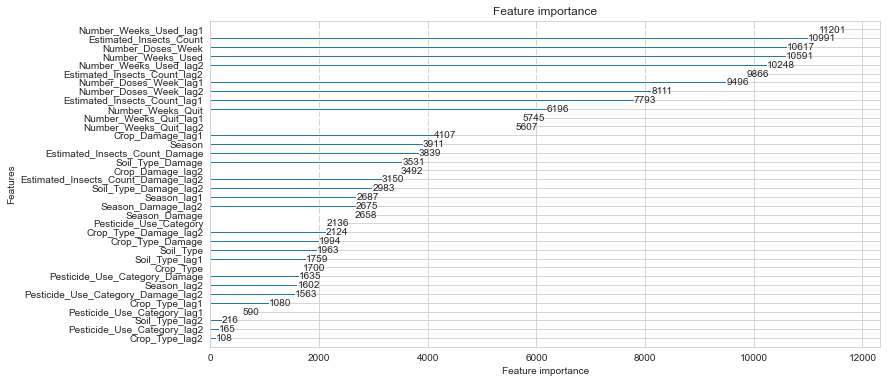

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()

In [ ]:
## some hard-coding done in excel for marginal probability values to improve accuracy (by ~ 0.005).